In [1]:
library(dplyr)
library(ggplot2)
library(forecast)
library(tseries)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
house_month_df <- read.csv('../input/housing-in-london/housing_in_london_monthly_variables.csv', header = TRUE)

In [3]:
head(house_month_df)

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<int>
1,1995-01-01,city of london,91449,E09000001,17,NA,1
2,1995-02-01,city of london,82203,E09000001,7,NA,1
3,1995-03-01,city of london,79121,E09000001,14,NA,1
4,1995-04-01,city of london,77101,E09000001,7,NA,1
5,1995-05-01,city of london,84409,E09000001,10,NA,1
6,1995-06-01,city of london,94901,E09000001,17,NA,1


In [4]:
dim(house_month_df)

[1] 13549     7

In [5]:
keep_col <- c('date', 'average_price')
house_month_df1 <- house_month_df[keep_col]

In [6]:
head(house_month_df1)
dim(house_month_df1)

,date,average_price
,<chr>,<int>
1,1995-01-01,91449
2,1995-02-01,82203
3,1995-03-01,79121
4,1995-04-01,77101
5,1995-05-01,84409
6,1995-06-01,94901


[1] 13549     2

In [7]:
house_month_df2 <- house_month_df1 %>% group_by(date) %>% summarise(average_price = mean(average_price))

In [8]:
dim(house_month_df2)

[1] 301   2

In [9]:
rownames(house_month_df2) <- house_month_df2$date

Warning message:
“Setting row names on a tibble is deprecated.”


In [10]:
head(house_month_df2)

date,average_price
<chr>,<dbl>
1995-01-01,75157.73
1995-02-01,74804.56
1995-03-01,74702.89
1995-04-01,74851.07
1995-05-01,75564.91
1995-06-01,76381.04


In [11]:
sum(is.na(house_month_df2))

[1] 0

In [12]:
avg_price <- house_month_df2$average_price

In [13]:
summary(avg_price)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  74703  150394  261328  263572  345859  474014 

In [14]:
sdev <- sd(avg_price)
cof_var <- sdev/mean(avg_price)*100
cof_var

[1] 48.10189

The coefficient of variation is around 48% which quite high(non-acceptable in most cases).

Graphical summary

In [15]:
housing_ts <- ts(avg_price, start = c(1995, 1), end = c(2020, 1), frequency = 12)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  74703  150394  261328  263572  345859  474014 

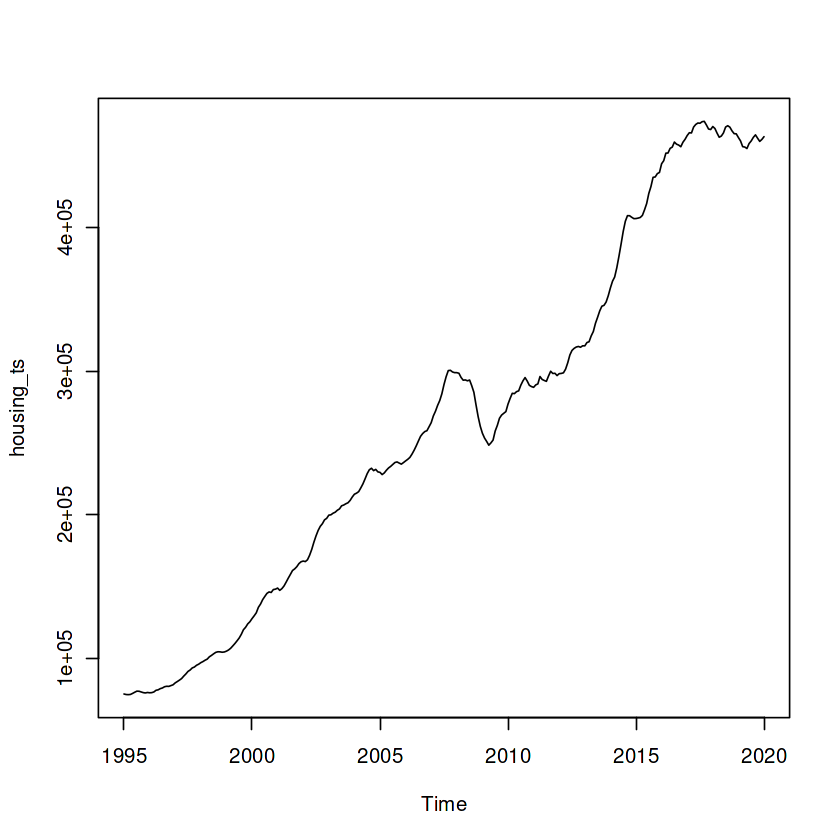

In [16]:
summary(housing_ts)
plot(housing_ts)

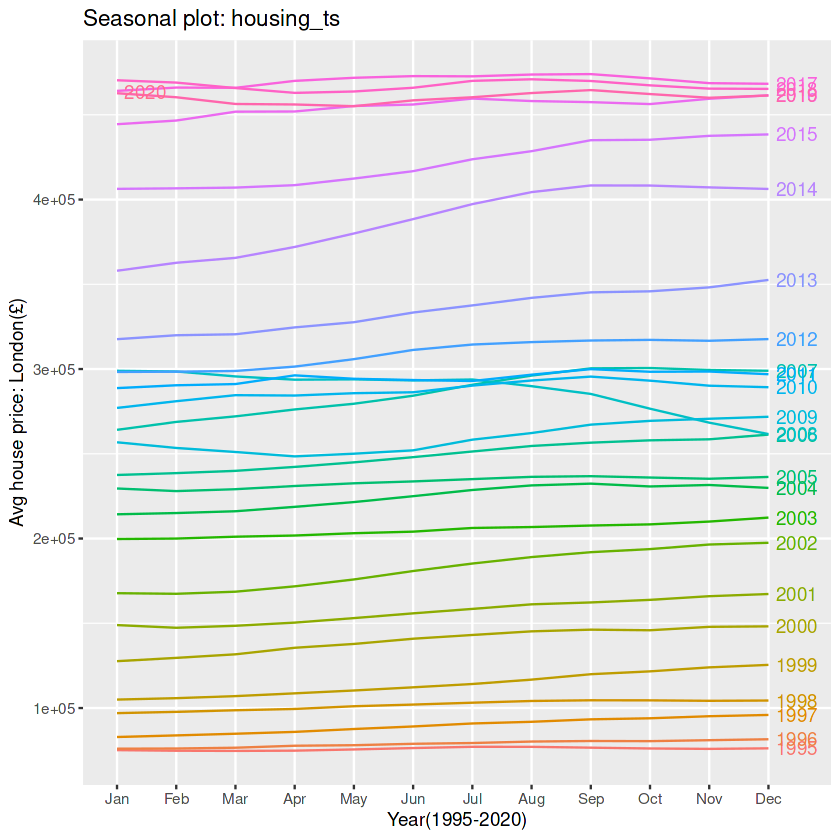

In [17]:
ggseasonplot(housing_ts, year.labels = T, years.labels.left = T) + ylab('Avg house price: London(£)') + xlab('Year(1995-2020)')

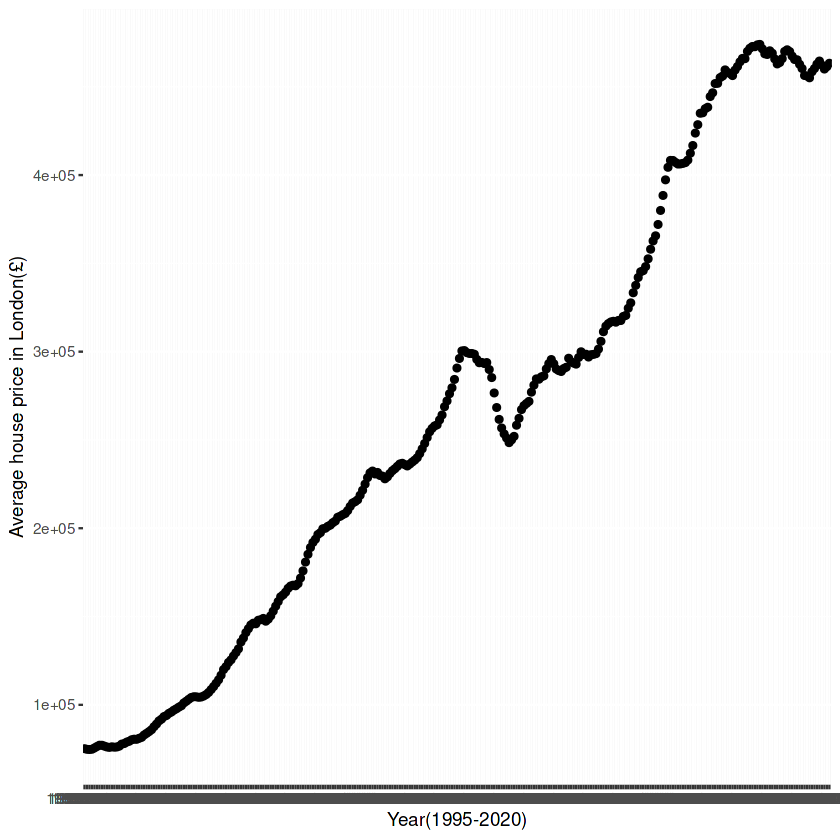

In [18]:
qplot(date, average_price, data = house_month_df2) + ylab('Average house price in London(£)') + xlab('Year(1995-2020)')

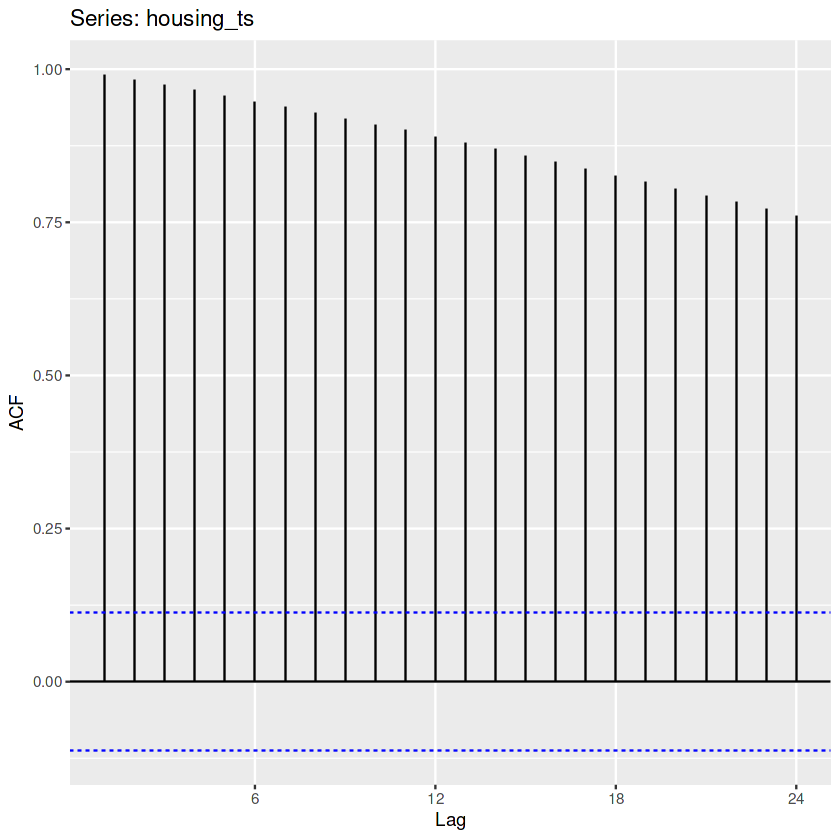

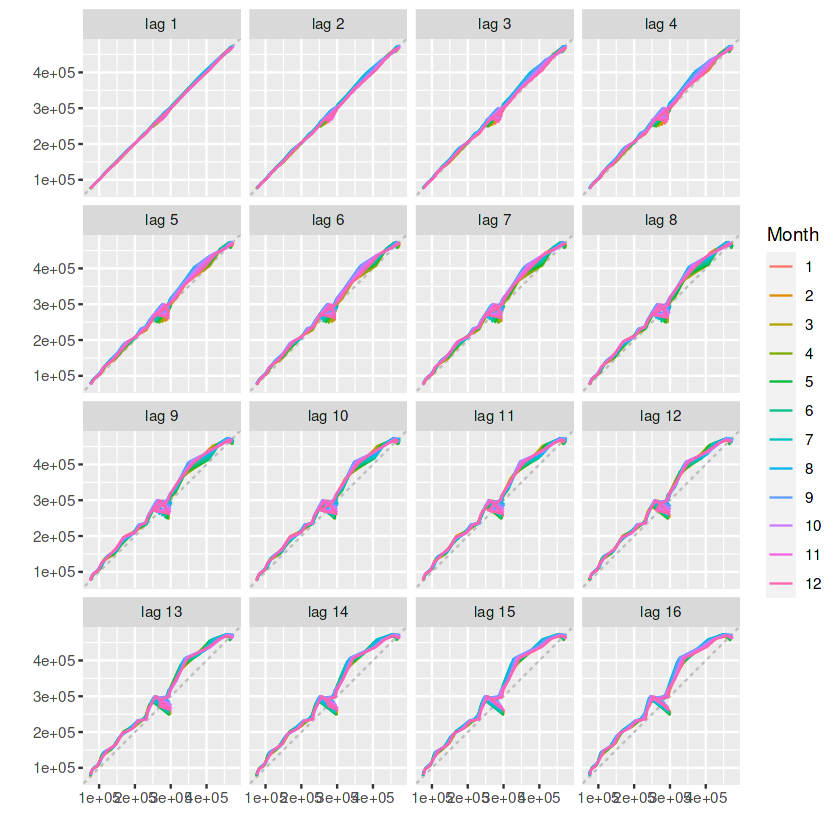

In [19]:
ggAcf(housing_ts)
gglagplot(housing_ts)

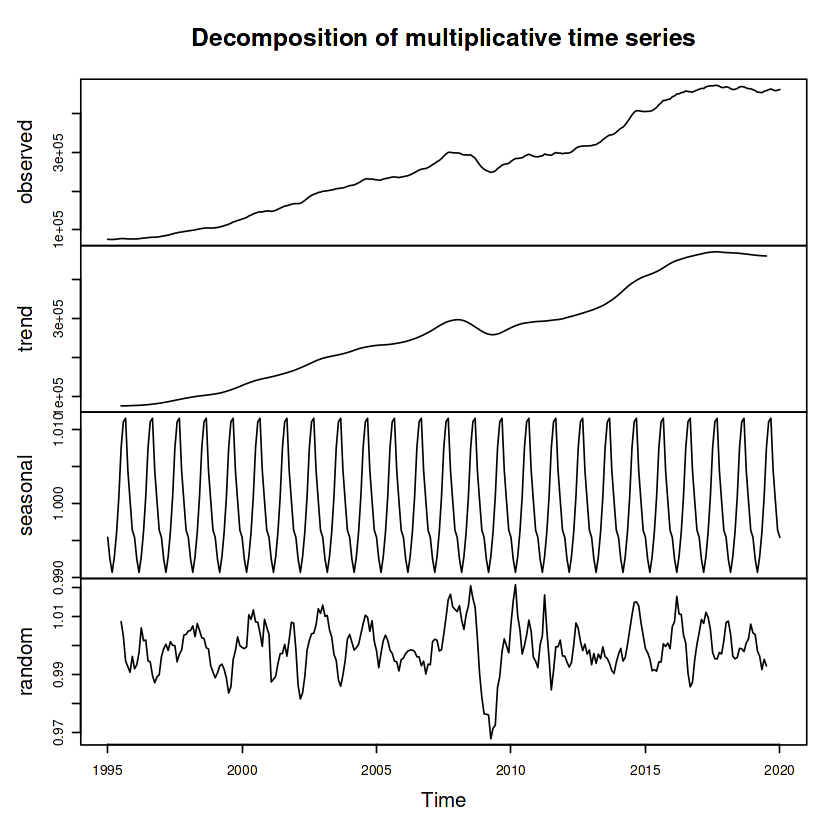

In [20]:
housing_ad <- decompose(housing_ts, 'multiplicative')
plot(housing_ad)

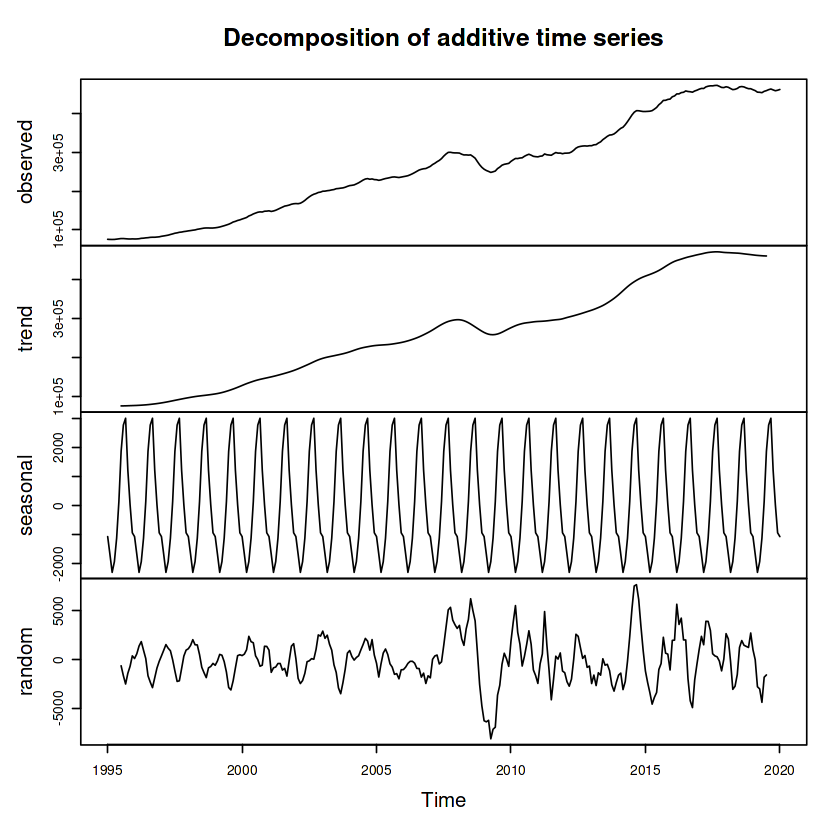

In [21]:
housing_ad <- decompose(housing_ts, 'additive')
plot(housing_ad)

Models

In [22]:
train_size <- length(avg_price)*0.8

house_train_df <- house_month_df2[1:train_size,]
train_pricing <- house_train_df$average_price
house_train_ts <- ts(train_pricing, start = c(1995, 1), frequency = 12)

In [23]:
house_test_df <- house_month_df2[-(1:train_size),]
test_pricing <- house_test_df$average_price

In [24]:
models_error_summary <- function(act_val, pred_val){                #Mean absolute percentage error
  mape <- mean(abs((act_val - pred_val)/act_val))*100
  mse <- sqrt(mean((act_val - pred_val)^2))
  return (c(mape, mse))
}

In [25]:
adf.test(house_train_ts)


	Augmented Dickey-Fuller Test

data:  house_train_ts
Dickey-Fuller = -2.2534, Lag order = 6, p-value = 0.4693
alternative hypothesis: stationary


p-value = 0.47 > significance value(0.05); Do not reject null hypothesis
data is non-stationary

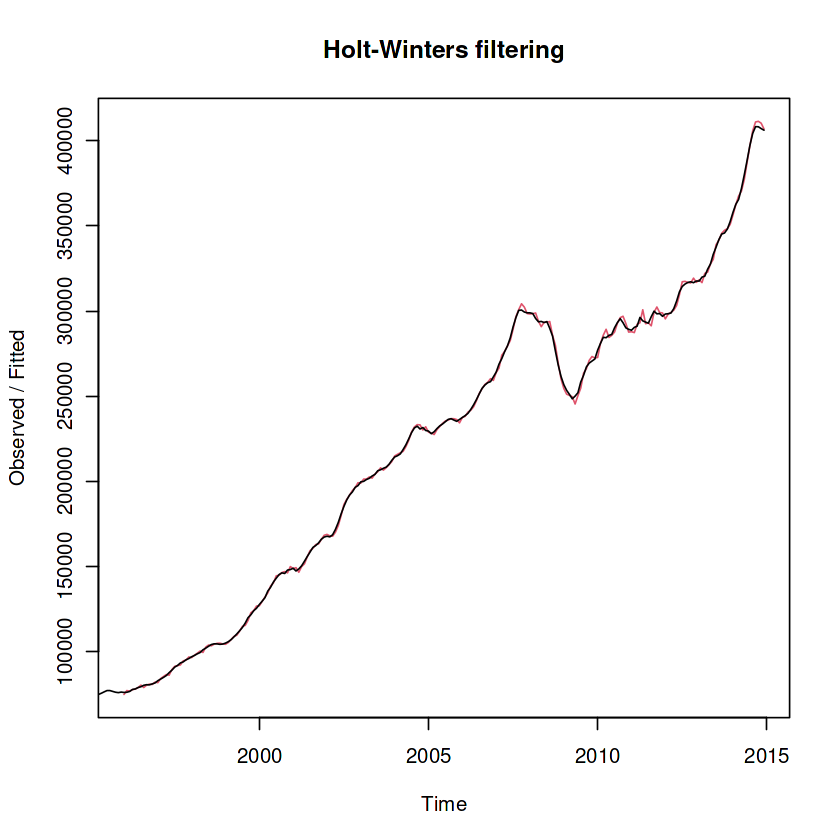

In [26]:
########HOLT'S WINTER########
house_hw <- HoltWinters(house_train_ts)
plot(house_hw)

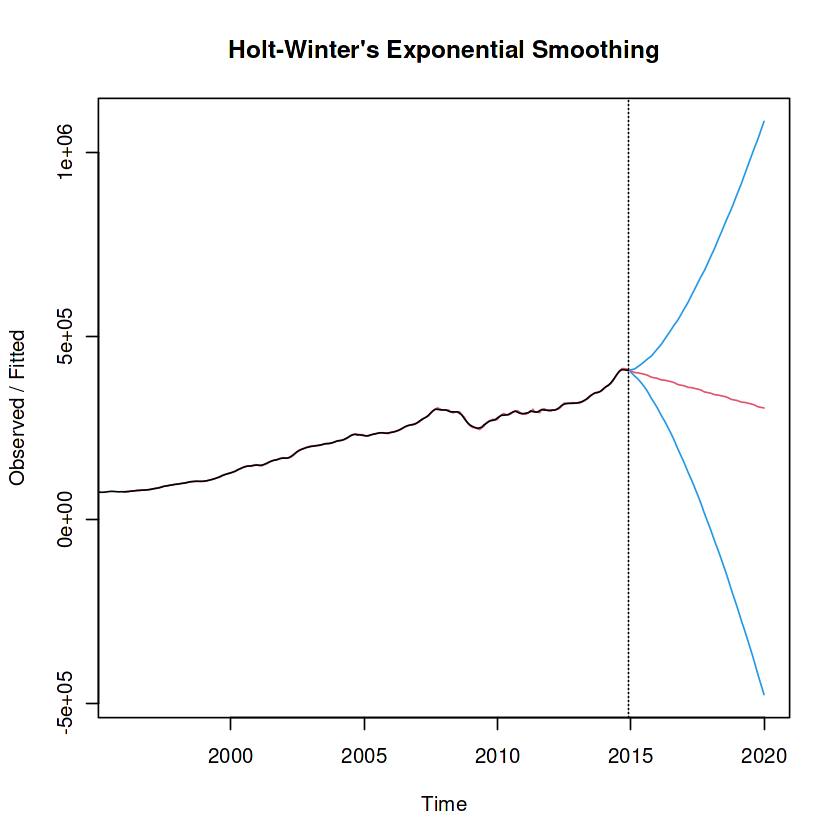

In [27]:
house_pred_hw <- predict(house_hw, n.ahead = 61, prediction.interval = T)
plot(house_hw, house_pred_hw, main = "Holt-Winter's Exponential Smoothing")

In [28]:
house_month_hw_df <- as.data.frame(house_pred_hw)

In [29]:
pred_price_hw <- house_month_hw_df$fit

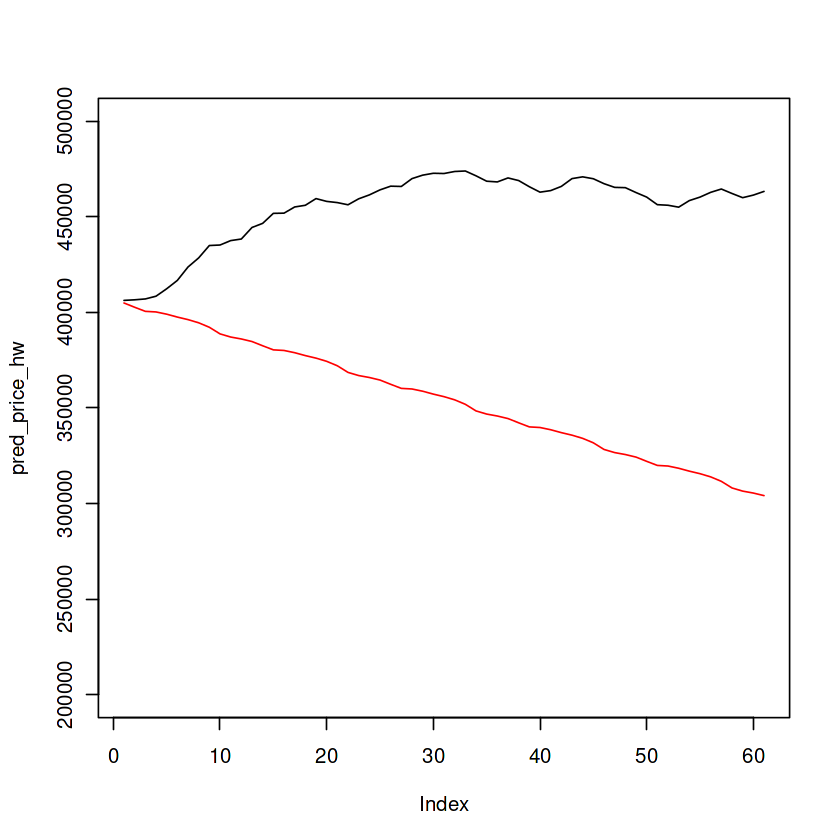

In [30]:
plot(pred_price_hw, type = 'l', ylim = c(200000,500000), col = 'red')
lines(test_pricing)

In [31]:
########ARIMA########
adf.test(house_train_ts)


	Augmented Dickey-Fuller Test

data:  house_train_ts
Dickey-Fuller = -2.2534, Lag order = 6, p-value = 0.4693
alternative hypothesis: stationary


0.47(p-value) > 0.05(significance value. 

Warning message in adf.test(house_train_ts_dif1):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  house_train_ts_dif1
Dickey-Fuller = -4.1187, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


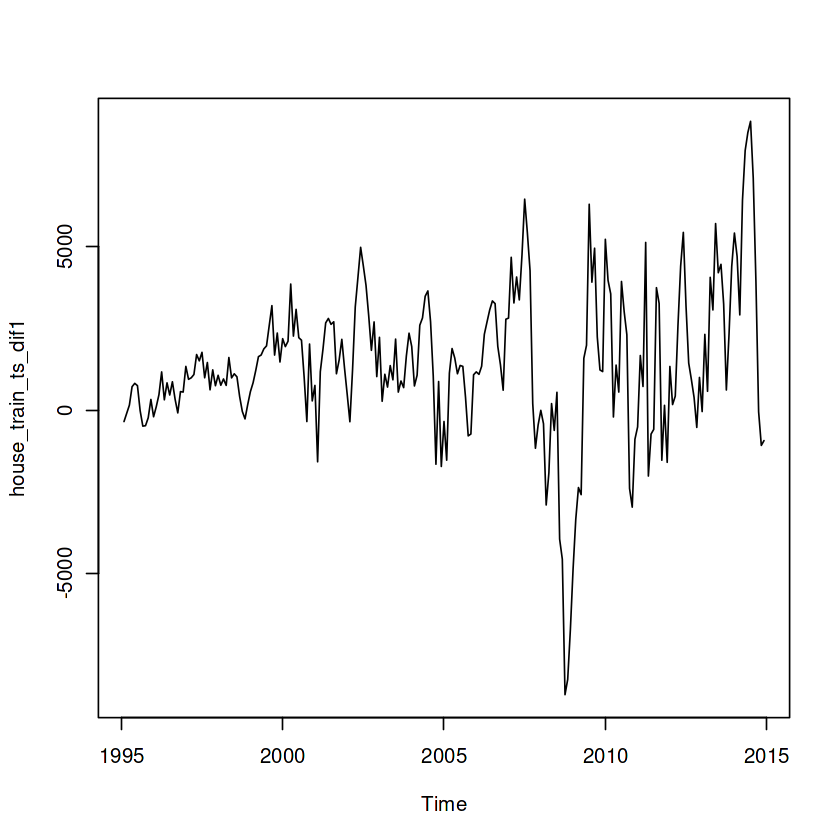

In [32]:
house_train_ts_dif1 <- diff(house_train_ts, differences = 1)
plot(house_train_ts_dif1)
adf.test(house_train_ts_dif1)

0.01(p-val) < 0.05(sign val). Hence, d = 1

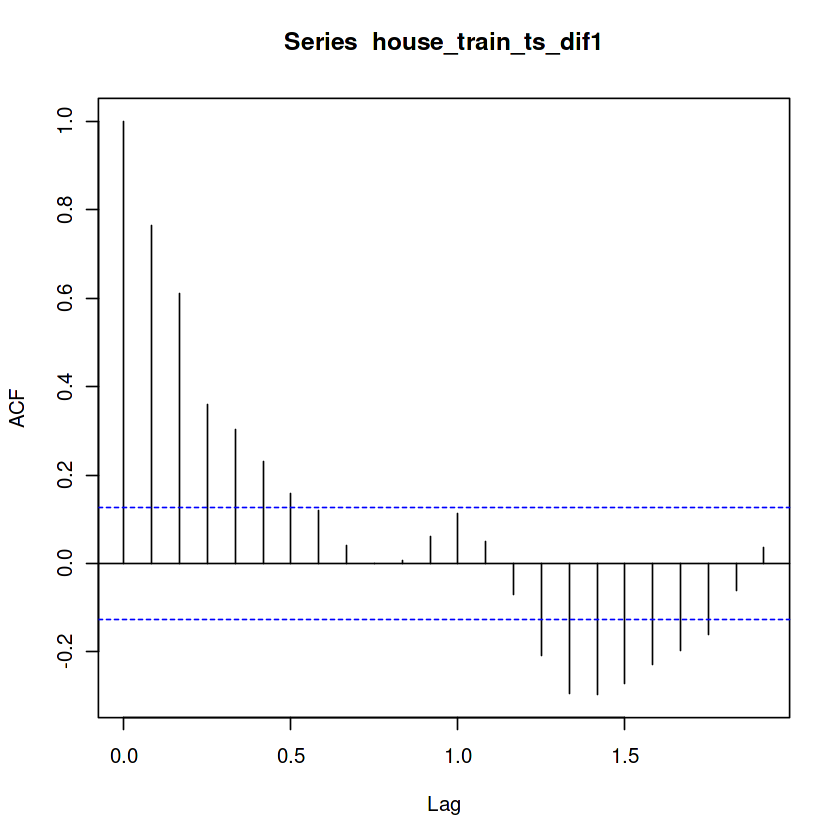

In [33]:
acf(house_train_ts_dif1)

q = 6
q = 2
q = 4

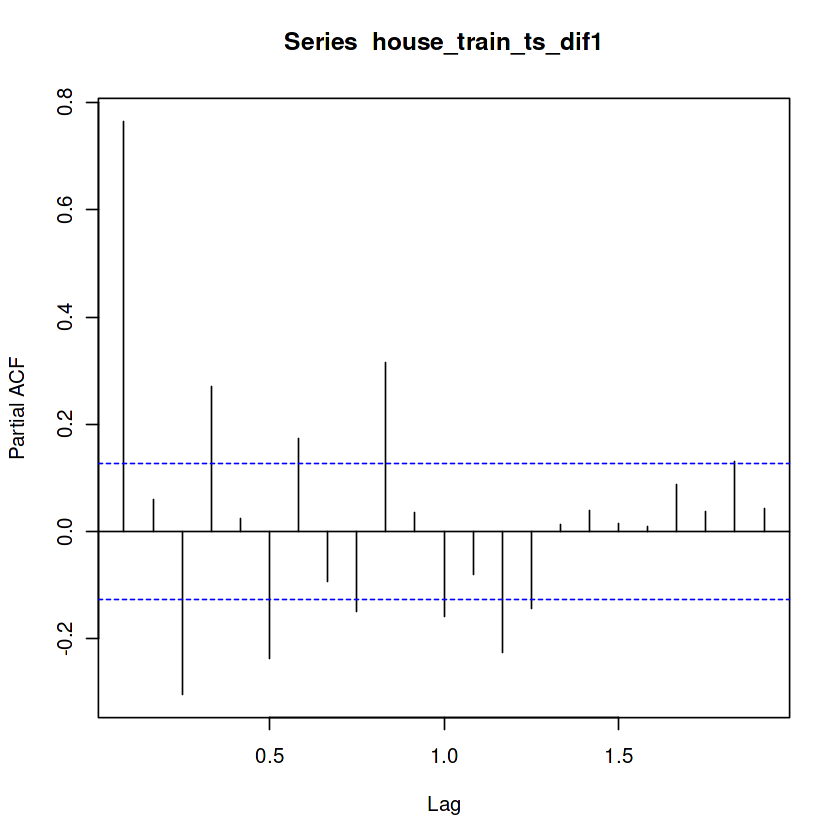

In [34]:
pacf(house_train_ts_dif1)

p = 2
p = 1

In [35]:
house_arima = arima(house_train_ts, order = c(1,1,4), seasonal = c(0,1,2))
house_arima


Call:
arima(x = house_train_ts, order = c(1, 1, 4), seasonal = c(0, 1, 2))

Coefficients:
         ar1      ma1     ma2      ma3     ma4     sma1     sma2
      0.8478  -0.0363  0.3258  -0.5435  0.2843  -0.7944  -0.0217
s.e.  0.0557   0.0866  0.0693   0.0692  0.0676   0.0737   0.0707

sigma^2 estimated as 1352547:  log likelihood = -1933.46,  aic = 3882.91

In [36]:
auto.arima(house_train_ts)

Series: house_train_ts 
ARIMA(1,1,4)(0,0,2)[12] with drift 

Coefficients:
         ar1     ma1     ma2      ma3     ma4   sma1    sma2      drift
      0.7649  0.1332  0.3954  -0.4378  0.2473  0.221  0.1670  1307.9976
s.e.  0.0847  0.1022  0.0965   0.0970  0.0663  0.071  0.0584   591.0876

sigma^2 = 1477880:  log likelihood = -2034.72
AIC=4087.43   AICc=4088.22   BIC=4118.72

In [37]:
house_a_arima = arima(house_train_ts, order = c(1,1,4), seasonal = c(0,0,2))
house_a_arima


Call:
arima(x = house_train_ts, order = c(1, 1, 4), seasonal = c(0, 0, 2))

Coefficients:
         ar1     ma1     ma2      ma3     ma4    sma1    sma2
      0.8225  0.0903  0.3631  -0.4705  0.2559  0.2404  0.1806
s.e.  0.0635  0.0863  0.0839   0.0837  0.0671  0.0708  0.0575

sigma^2 estimated as 1448994:  log likelihood = -2036.6,  aic = 4089.21


	Ljung-Box test

data:  Residuals from ARIMA(1,1,4)(0,1,2)[12]
Q* = 37.791, df = 17, p-value = 0.002626

Model df: 7.   Total lags used: 24



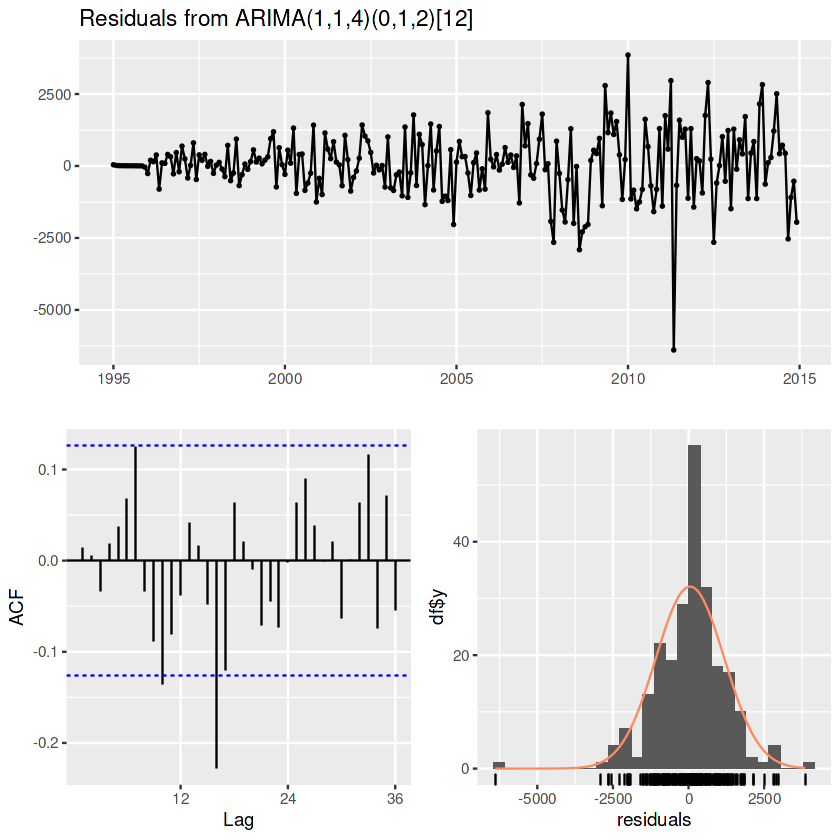


	Ljung-Box test

data:  Residuals from ARIMA(1,1,4)(0,0,2)[12]
Q* = 29.827, df = 17, p-value = 0.02762

Model df: 7.   Total lags used: 24



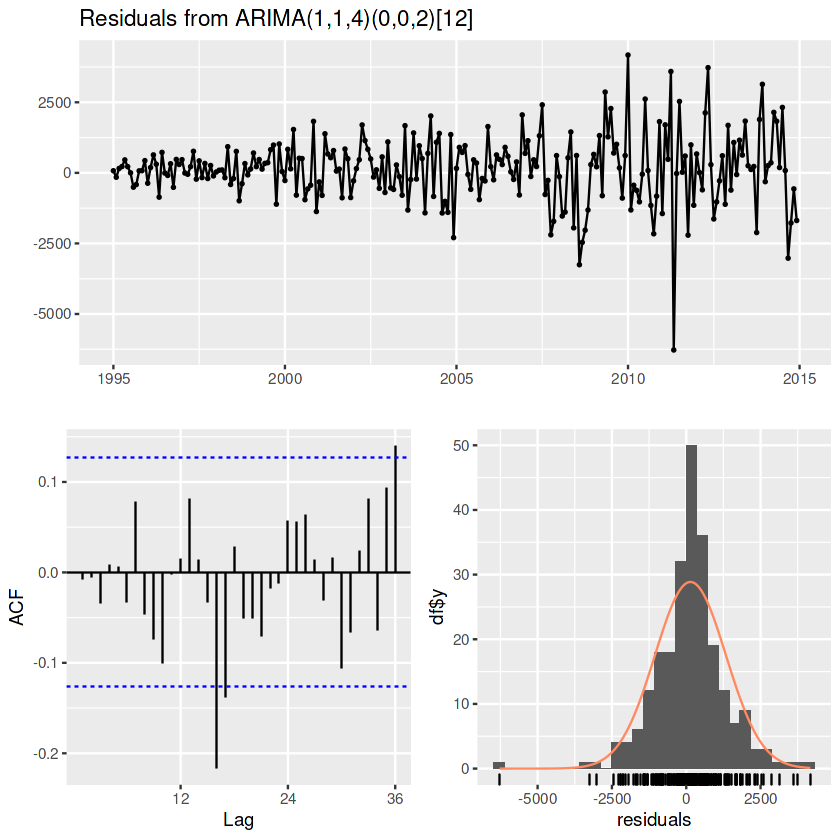

In [38]:
checkresiduals(house_arima)
checkresiduals(house_a_arima)

In [39]:
house_pred_arima <- predict(house_arima, n.ahead = 61)

In [40]:
house_pred_a_arima <- predict(house_a_arima, n.ahead = 61)

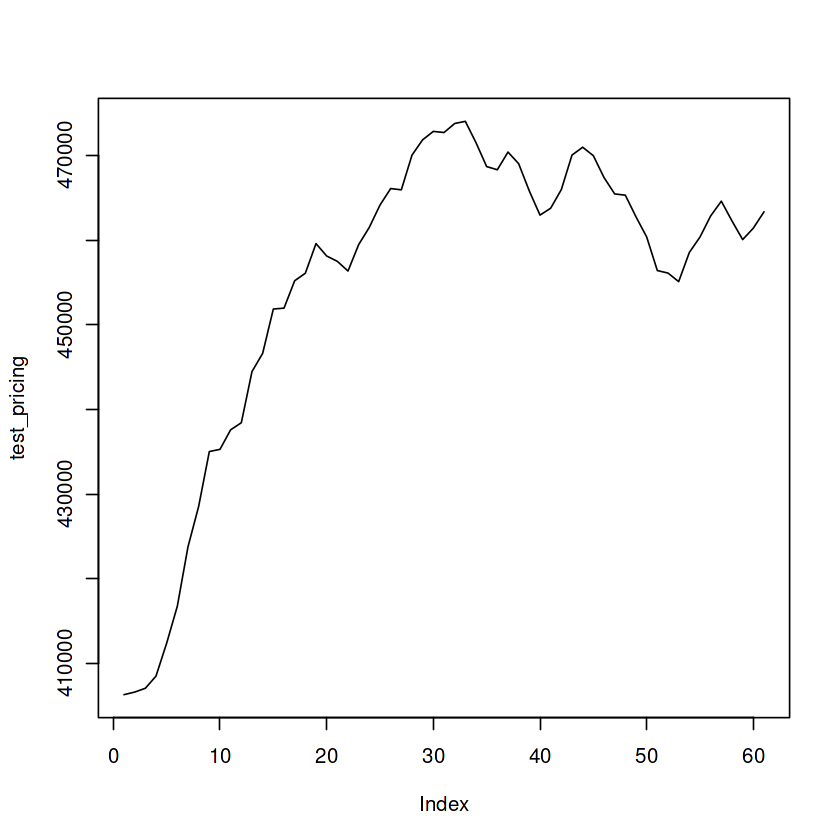

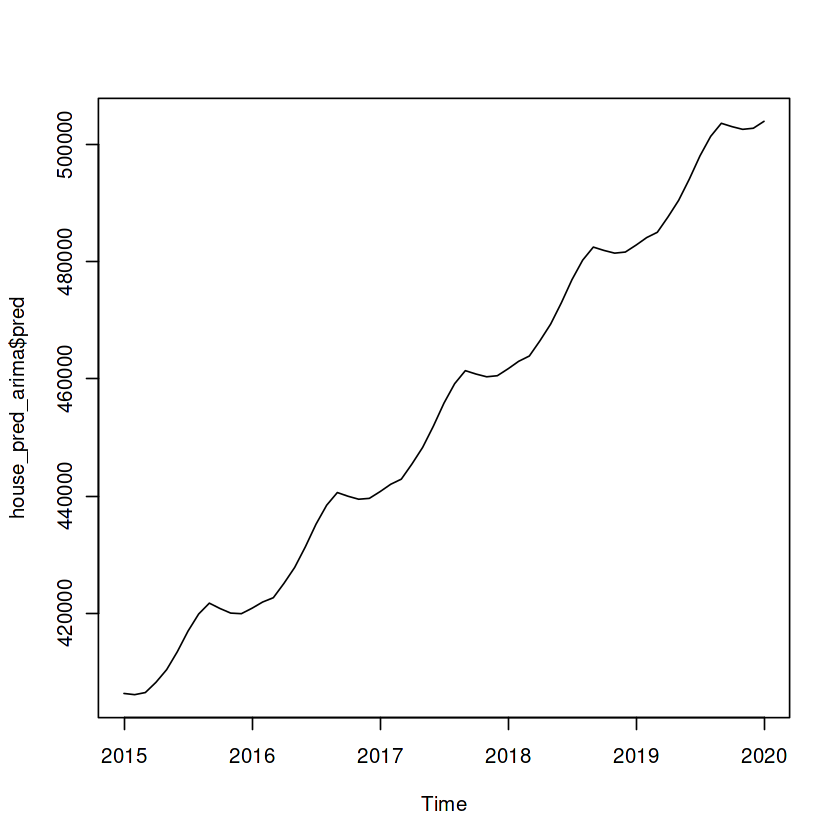

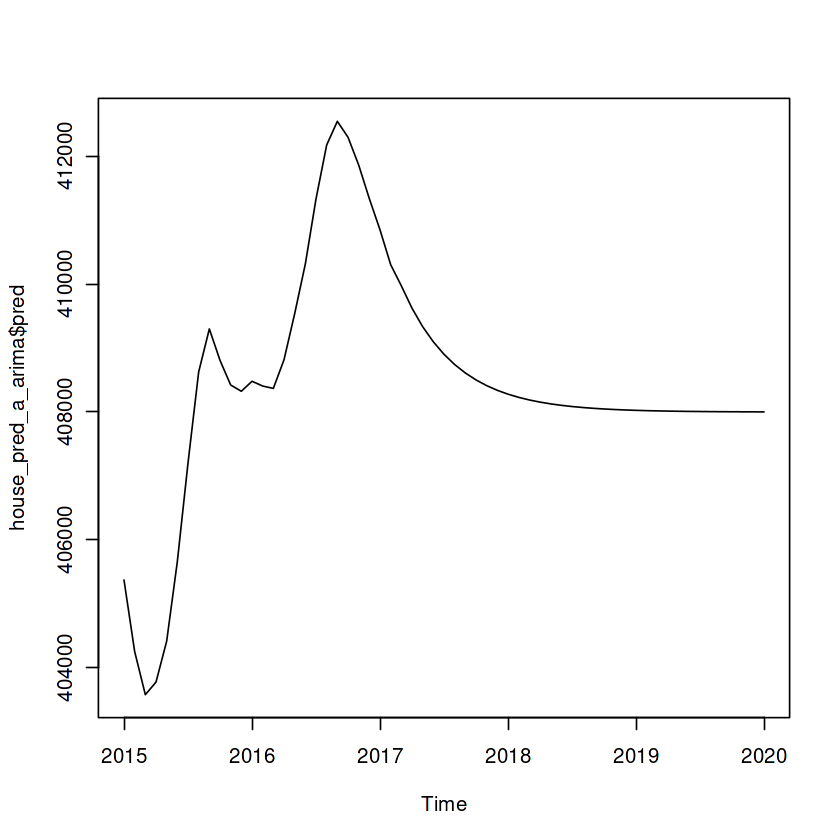

In [41]:
plot(test_pricing, type = 'l')
plot(house_pred_arima$pred, type = 'l')
plot(house_pred_a_arima$pred, type = 'l')

Evaluation

[1]     21.68041 109623.17176

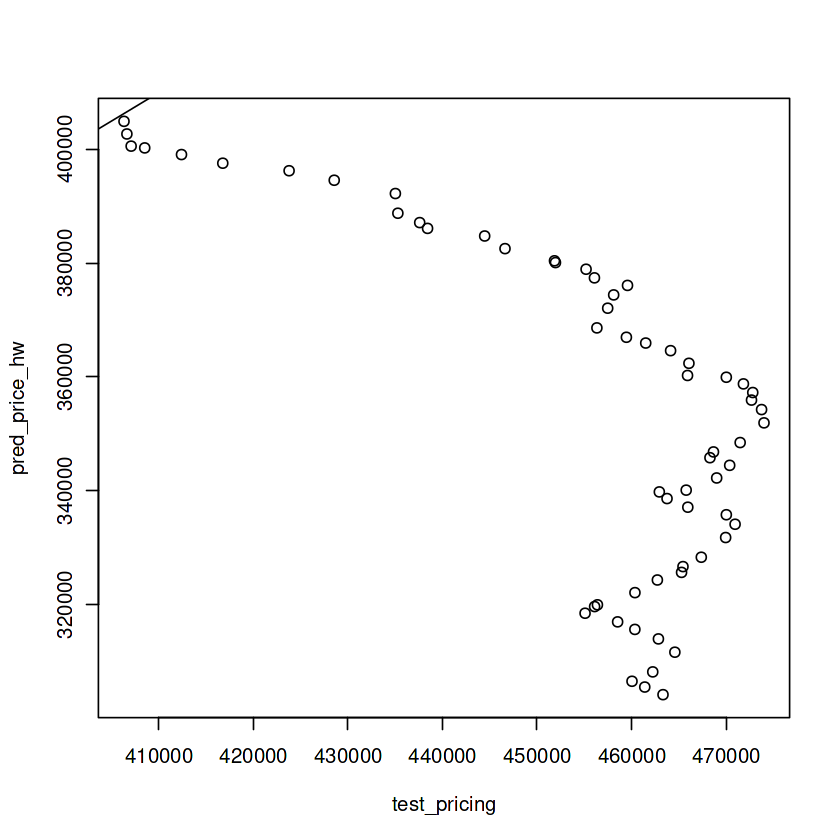

In [42]:
models_error_summary(test_pricing, pred_price_hw)
plot(test_pricing, pred_price_hw)
abline(a=0,b=1)

[1]     4.057234 22048.243329

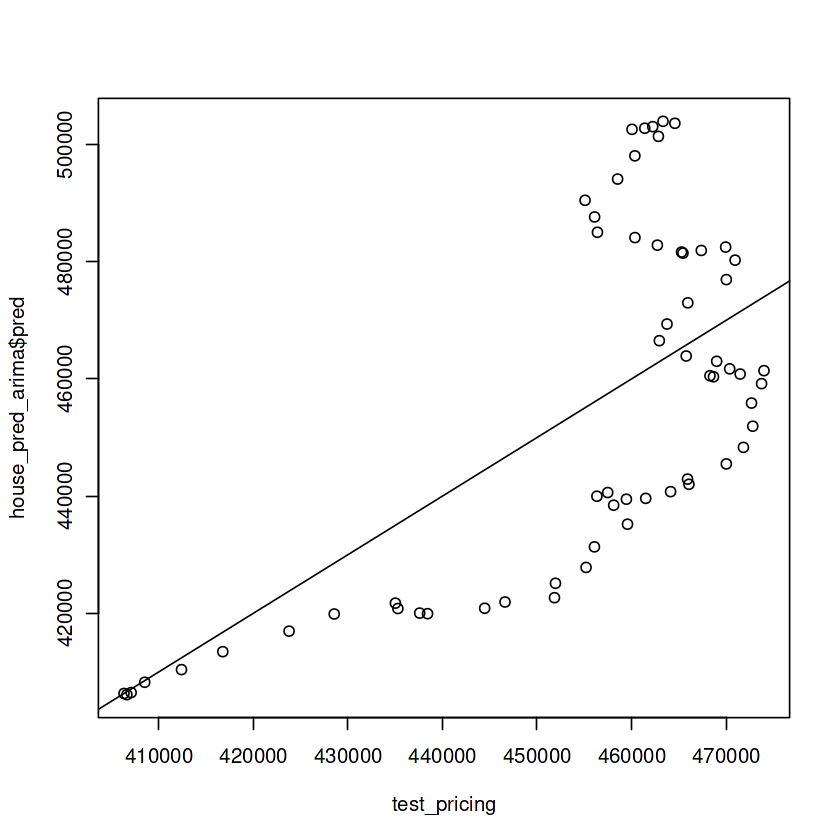

In [43]:
models_error_summary(test_pricing, house_pred_arima$pred)
plot(test_pricing, house_pred_arima$pred)
abline(a=0, b=1)

[1]    10.05181 49596.06044

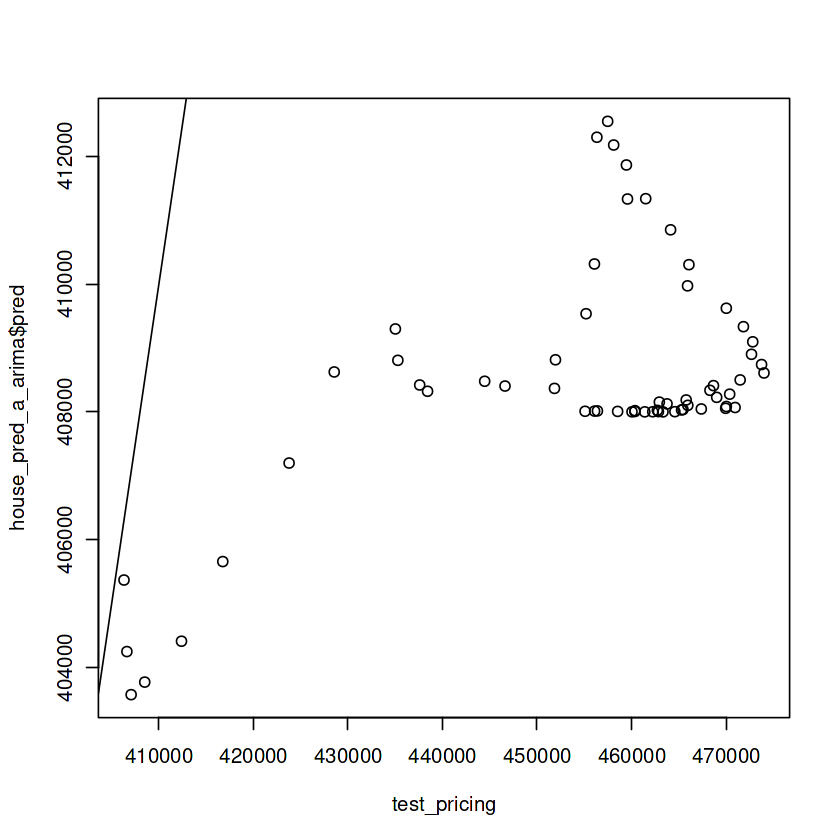

In [44]:
models_error_summary(test_pricing, house_pred_a_arima$pred)
plot(test_pricing, house_pred_a_arima$pred)
abline(a=0, b=1)

Forecast

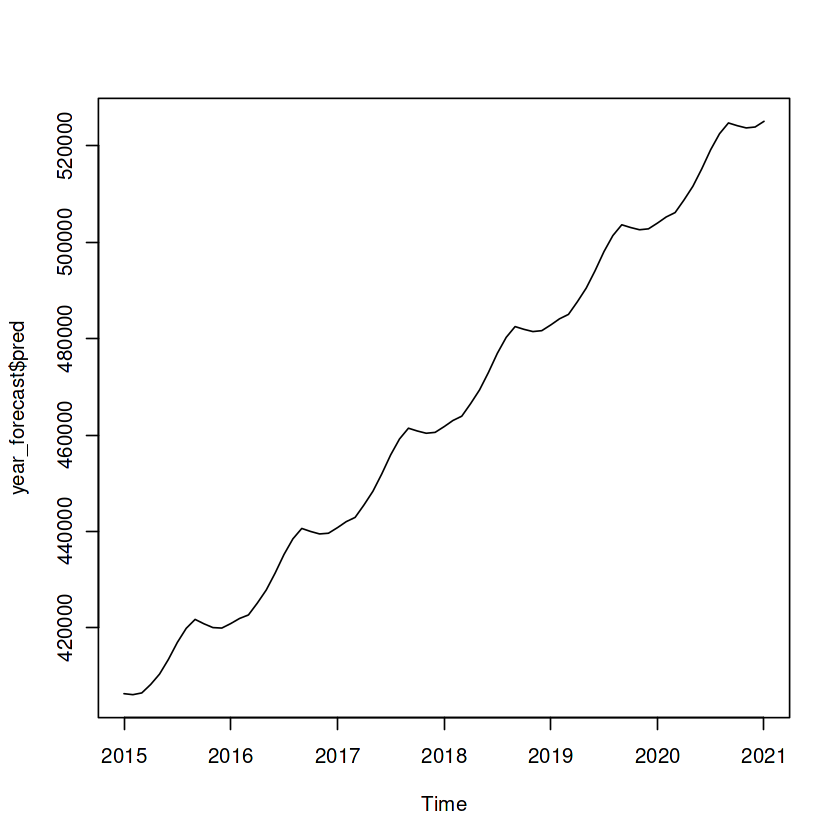

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 406100  435200  461719  464596  498082  525109 

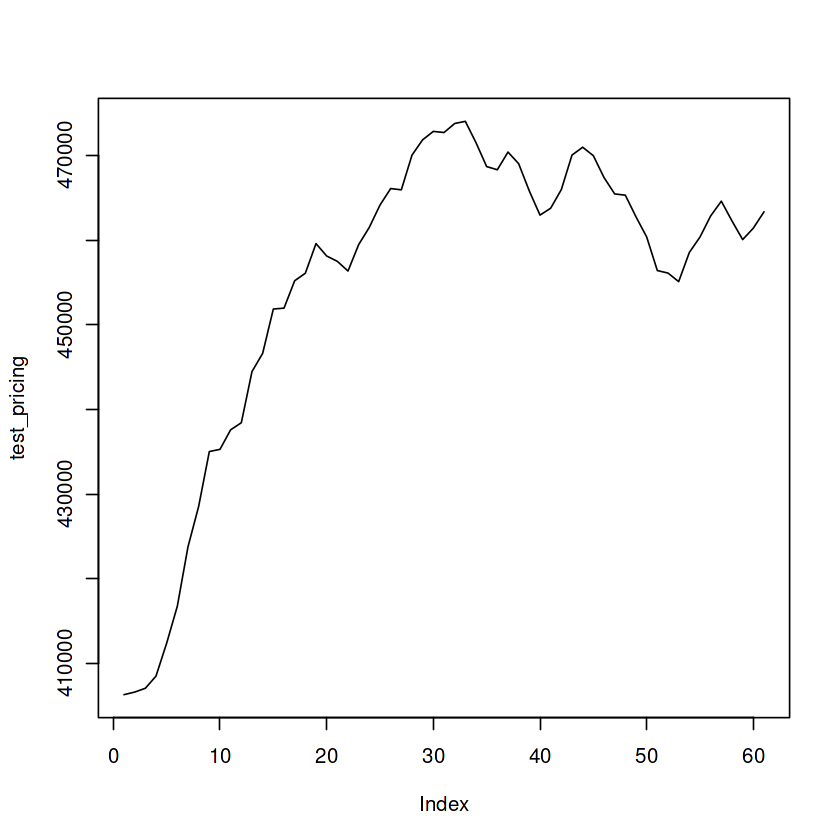

In [45]:
year_forecast <- predict(house_arima, n.ahead = 73)
plot(year_forecast$pred)
plot(test_pricing, type = 'l')
summary(year_forecast$pred)